# NOTES (DELETE LATER):
# - Made this alternate file just for a clearer version of the overall structure
# - made changes to the data tidying, details are in the notebook
# - first VIF check before splitting data 70/30
# - using full set for first VIF check
# - using training set for final model fitting with stepAIC
# - only using testing set for later validation
# - "Occupation: Accountant" is absorbed into reference row (Intercept) in stepAIC
# - "SleepDisorder: None" is absorbed into reference row (Intercept) in stepAIC
# - therefore in the summary of the stepAIC, values for the rows for the levels of the occupation variables are produced in relation to the reference level "Accountant", and for all numerical rows the values are in association with the response variable
# - Not sure of validation is needed but included in case we need it

# Introduction

# Explanatory Modelling with Multiple Linear Regression

Members:
- Mark Cao 
- Aarush Agarwal
- Edward Kim
- Ibrahim Saeed

Aptil 16, 2025

Sleep plays a crucial role in maintaining physical and mental health. Disruptions in sleep quality or duration have been consistently associated with increased stress levels, cardiovascular risk, and metabolic issues such as obesity. As lifestyles become more demanding and sedentary, understanding how daily habits impact sleep health is both timely and essential. For this project, we use the Sleep Health and Lifestyle Dataset which contains 374 observations and 13 variables, covering sleep quality, daily activity, stress, and cardiovascular health. It includes numerical and categorical data, such as sleep duration (hours), self-reported sleep quality (1-10 scale), physical activity level (minutes/day), stress level (1-10 scale), BMI category, and presence of sleep disorders (None, Insomnia, Sleep Apnea). This dataset helps analyze the relationship between lifestyle choices and sleep health. 

Our inference-based research question is as follows:
We wish to examine the association between a person's sleep duration and health-routine-related predictors such as BMI, physical activity level, sleep disorder, stress level, etc.
Our question is primarily focused on inference, as our goal is to examine association intead of predicting values. By examining the model’s coefficients, we can interpret how each factor contributes to changes in sleep duration, providing insights into potential lifestyle adjustments for better sleep health.

There’s already quite a bit of research highlighting how lifestyle choices are connected to sleep health. For example, Grandner (2017) points out that behaviors like physical activity and diet play an important role in sleep quality. Medic et al. (2017) explain how poor sleep can affect both mental and physical health, especially through stress and cardiovascular issues. Similarly, Khan and Aouad (2017) show links between sleep loss and cardiovascular risk factors like high BMI and blood pressure. These studies help back up the relevance of the variables we’re exploring and show why it makes sense to look for associations between them and sleep disorders in this project.

# Libraries

In [1]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)
library(MASS)
library(car)
library(rsample)
library(ggplot2)

print("LIBRARIES LOADED")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




[1] "LIBRARIES LOADED"


# Data

In [2]:
file_url <- "https://drive.google.com/uc?export=download&id=1ZjZvLl5dUzHEF8ouimlTg8t0MorhjzVA"
sleep_data <- read.csv(file_url)
head(sleep_data)
set.seed(114514) # SEED, DO NOT CHANGE

,Person.ID,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Blood.Pressure,Heart.Rate,Daily.Steps,Sleep.Disorder
,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


Dataset used: Laksika Tharmalingam. 2024. Sleep Health and Lifestyle Dataset. Retrieved from https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data

A detailed description of all the variables in the dataset is as follows:-

| Variable | Type of Variable | Description |
| -------- | --------------- | ----------- |
| Person ID | Numeric | Unique identifier for each individual |
| Gender | Categorical | Gender of the individual (Male/Female) |
| Age | Numeric | Age of the individual in years |
| Occupation | Categorical | Job or profession of the individual |
| Sleep Duration | Numeric | Number of hours a person sleep per day |
| Quality of Sleep | Numeric | Subjective sleep quality rating (1-10) |
| Physical Activity Level | Numeric | Minutes of physical activity of an individual per day |
| Stress Level | Numeric | Subjective stress level of a person (1-10) |
| BMI Category | Categorical | BMI classification (Underweight, Normal, Overweight) |
| Blood Pressure  | Numeric | The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. |
| Heart Rate | Numeric | Resting heart rate in beats per minute |
| Daily Steps | Numeric | Number of steps taken per day |
| Sleep Disorder | Categorical | Presence of a sleep disorder (None, Insomnia, Sleep Apnea) |

#### The source of the dataset states that the set is synthetic and was generated for illustrative purposes.


# Tidying and pre-selection

Tidying the data for modelling:
-  We remove the PersonID column, as it provides no statistical information.
-  For readability, we replace all column names, categorical level names, and other string data with versions without periods or whitespace in between characters.
-  For readability we replace these column names: "QualityofSleep" -> "SleepQuality", and "PysicalActivityLevel" -> "PhysicalActivity".
-  We perform factor conversion to all categorical variables.
- We replace the "BloodPressure" column with two new columns "SystolicPressure" and "DiastolicPressure" to maintain proper numerical columns for modelling.
- For simplicity we replace all "Obese" entries in BMICategory with "Overweight" so that only two levels remain: "Normal" and "Overweight"
- For simplicity we replace all SleepDisorder entries with either "None" for no sleep disorder and "Present" for any kind of sleep disorder.
- For future interpretability we replace the DailySteps column with Daily1000Steps for the number of daily steps of an individual divided by 1000.
- For future interpretability we divide all entries in PhysicalActivity by 60 to represent daily physical activity level of an individual in hours instead of minutes.
  
We set the reference level for each categorical variable as the following:
- BMICategory: "Normal"
- SleepDisorder: "None"
- Gender: "Male"
- Occupation: "Accountant"

In terms of pre-selection, the only complete removal was the PersonID column.


In [3]:
sleep_data_reduced <- sleep_data |>
dplyr::select(-`Person.ID`) %>%
{ names(.) <- names(.) |> str_replace_all("[\\.\\s]", "")
.} %>%
mutate(Occupation = str_replace_all(Occupation, "[\\.\\s]", "")) |>
mutate(PhysicalActivityLevel = PhysicalActivityLevel / 60) |>
separate(BloodPressure, into = c("SystolicPressure", "DiastolicPressure"), sep = "/") |>
mutate(across(c(SystolicPressure, DiastolicPressure), as.numeric)) |>
mutate(BMICategory = if_else(str_detect(BMICategory, "Obese"), "Overweight", BMICategory)) |>
mutate(SleepDisorder = if_else(SleepDisorder == "None", "None", "Present")) |>
mutate(Daily1000Steps = DailySteps / 1000) |>
dplyr::select(-DailySteps) |>
rename(SleepQuality = QualityofSleep, PhysicalActivity = PhysicalActivityLevel) |>
mutate(
    BMICategory = fct_relevel(BMICategory, "Normal"),
    SleepDisorder = fct_relevel(SleepDisorder, "None"),
    Gender = fct_relevel(Gender, "Male"),
    Occupation = fct_relevel(Occupation, "Accountant")
  ) |>
mutate(across(where(is.character), as_factor))

head(sleep_data_reduced) 
nrow(sleep_data_reduced)

,Gender,Age,Occupation,SleepDuration,SleepQuality,PhysicalActivity,StressLevel,BMICategory,SystolicPressure,DiastolicPressure,HeartRate,SleepDisorder,Daily1000Steps
,<fct>,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<int>,<fct>,<dbl>
1,Male,27,SoftwareEngineer,6.1,6,0.7,6,Overweight,126,83,77,None,4.2
2,Male,28,Doctor,6.2,6,1.0,8,Normal,125,80,75,None,10.0
3,Male,28,Doctor,6.2,6,1.0,8,Normal,125,80,75,None,10.0
4,Male,28,SalesRepresentative,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0
5,Male,28,SalesRepresentative,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0
6,Male,28,SoftwareEngineer,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0


[1] 374

We note again that the new tidy and pre-selected dataset contains:

- "SleepQuality" name change from "QualityofSleep"
- "PhysicalActivity" as HOURS of physical activity per day instead of minutes
- "BMICategory" as either normal or overweight
- "SystolicPressure" from the systolic part of the blood pressure column
- "DiastolicPressure" from the diastolic part of the blood pressure column
- "SleepDisorder" as either None or Present
- "Daily1000Steps" for steps per day divided by 1000

# Explanatory Data Analysis

### EDA starts here ***

### Also include visualizations for EDA ***

# Methods

INFERENCE QUESTION: TO SEE IF THERE IS AN ASSOCIATION BETWEEN RESPONSE VARIABLE SLEEP DURATION AND OTHER HEALTH AND ROUTINE FACTORS SUCH AS PHYSICAL ACTIVITY, OCCUPATION, AGE, STRESS LEVEL.

## Explain chosen method and justification here ***

### Assumptions:
- Linear relationship between Sleep duration(response) and the person's physical and mental health(input)
- Errors are independent
- Conditional distribution of the error term is normal
- Variances of the error term are equal
- Furthermore, I will use variable selection methods to minimize the effect of multicollinearity.
### Potential drawbacks and limitations:
- Even though sleep duration is a continuous variable, the relationship might not be perfectly linear
- Potential issues with our variable selection step.

### Initial VIF check
First we do a quick VIF check using the full data set:

In [4]:
# FIRST VIF CHECK WITH FULL DATA
sleep_full <- lm(SleepDuration~., data=sleep_data_reduced)
vif(sleep_full)

,GVIF,Df,GVIF^(1/(2*Df))
Gender,10.932216,1,3.306390
Age,18.971538,1,4.355633
Occupation,1177.791727,10,1.424142
SleepQuality,26.975100,1,5.193756
PhysicalActivity,6.500727,1,2.549652
StressLevel,19.891609,1,4.460001
BMICategory,19.861614,2,2.111075
SystolicPressure,89.348757,1,9.452447
DiastolicPressure,109.719392,1,10.474702
HeartRate,5.534900,1,2.352637


### Variables with high scaled-GVIF:

SleepQuality, SystolicPressure, DiastolicPressure.

### VIF-based selection

Here we choose to manually remove the "DiastolicPressure" column from the model:

- It has high multicollinearity with SystolicPressure
- To simply the model and increase performance while keeping a similar representation to having both blood pressure values

In [5]:
# MANUALLY REMOVE PROBLEMATIC DIASTOLIC PRESSURE COLUMN
sleep_step_ready <- sleep_data_reduced |>
  dplyr::select(-DiastolicPressure)

### Data splitting

After removing the problematic column,

we then split the data 70/30, training/testing:

In [6]:
# SPLITTING
data_split <- sleep_step_ready |> initial_split(prop = 0.7, strata = SleepDuration)
sleep_train <- training(data_split)
sleep_test <- testing(data_split)
print(paste("TRAINING N-ROWS:", nrow(sleep_train)))
print(paste("TESTING N-ROWS:", nrow(sleep_test)))

[1] "TRAINING N-ROWS: 260"
[1] "TESTING N-ROWS: 114"


# Model selection

### Explain variable selection method here ***

After splitting, we refit the full model and then use the training set to fit the final model:

In [7]:
# RE-FIT FULL MODEL WITH TRAINING SET WITH PROBLEMATIC COLUMN REMOVED
sleep_full <- lm(SleepDuration~., data=sleep_train)
# STEP AIC WITH FULL MODEL FROM TRAINING SET
aic_model <- stepAIC(sleep_full, direction = "backward", k = log(nrow(sleep_train)))

Start:  AIC=-623.2
SleepDuration ~ Gender + Age + Occupation + SleepQuality + PhysicalActivity + 
    StressLevel + BMICategory + SystolicPressure + HeartRate + 
    SleepDisorder + Daily1000Steps

                   Df Sum of Sq    RSS     AIC
- BMICategory       2    0.1367 14.916 -631.92
- HeartRate         1    0.0036 14.783 -628.69
- Gender            1    0.0250 14.805 -628.32
<none>                          14.780 -623.20
- Age               1    0.3880 15.168 -622.02
- SleepDisorder     1    0.4600 15.240 -620.79
- Daily1000Steps    1    0.4675 15.247 -620.66
- StressLevel       1    0.4908 15.271 -620.26
- SleepQuality      1    1.5230 16.303 -603.26
- SystolicPressure  1    1.6718 16.451 -600.89
- PhysicalActivity  1    2.0420 16.822 -595.11
- Occupation       10    8.0189 22.799 -566.11

Step:  AIC=-631.92
SleepDuration ~ Gender + Age + Occupation + SleepQuality + PhysicalActivity + 
    StressLevel + SystolicPressure + HeartRate + SleepDisorder + 
    Daily1000Steps

      

In [8]:
full_vars <- attr(terms(sleep_full),"term.labels")
final_vars <- attr(terms(aic_model),"term.labels")
dropped_vars <- setdiff(full_vars, final_vars)
print(dropped_vars)

[1] "Gender"      "BMICategory" "HeartRate"  


### Interpretation:

These variables were dropped after stepAIC: Gender, BMICategory, HeartRate.



# Results

Taking a look at the summary of the stepAIC-selected model:

In [9]:
model_results <- tidy(aic_model)
print("1.")
print("GENERAL RESULTS OF THE FINAL MODEL:")
print(model_results)
model_results$direction <- ifelse(
  model_results$p.value < 0.05,
  ifelse(model_results$estimate > 0, "Positive", "Negative"),"Neither")
occupation_vars <- model_results[grepl("^Occupation", model_results$term), ]
sleep_disorder_var <- model_results[grepl("^SleepDisorder", model_results$term), ]
non_occupation_vars <- model_results[!grepl("^Occupation|^SleepDisorder|\\(Intercept\\)", model_results$term), ]
print("2.")
print("OCCUPATION LEVELS (relative to reference: Accountant):")
print(occupation_vars)
print("3.")
print("SLEEP DISORDER VARIABLE (relative to reference: None):")
print(sleep_disorder_var)
print("4.")
print("ALL OTHER NUMERICAL VARIABLES:")
print(non_occupation_vars)

[1] "1."
[1] "GENERAL RESULTS OF THE FINAL MODEL:"
# A tibble: 18 × 5
   term                          estimate std.error statistic  p.value
   <chr>                            <dbl>     <dbl>     <dbl>    <dbl>
 1 (Intercept)                     9.06     0.856       10.6  8.89e-22
 2 Age                             0.0218   0.00504      4.33 2.15e- 5
 3 OccupationDoctor                0.947    0.0777      12.2  6.23e-27
 4 OccupationEngineer              0.822    0.0777      10.6  1.03e-21
 5 OccupationLawyer                0.823    0.103        7.99 5.55e-14
 6 OccupationManager               0.302    0.263        1.15 2.53e- 1
 7 OccupationNurse                 0.566    0.101        5.62 5.26e- 8
 8 OccupationSalesperson           0.636    0.0916       6.94 3.52e-11
 9 OccupationSalesRepresentative   1.63     0.239        6.82 7.26e-11
10 OccupationScientist             0.730    0.182        4.01 8.01e- 5
11 OccupationSoftwareEngineer      0.691    0.258        2.68 7.92e- 3
12 Occu

### Interpretation:

From these results from the stepAIC-selected model, we conclude that the chosen factors indeed have a significant association with the response variable sleep duration.

We use the common threshold of p<0.05 to assess significance.

NOTE: THE SIGNIFICANCE VALUES FOR THE LEVELS OF THE CATEGORICAL VARIABLE OCCUPATION ARE PRODUCED IN ASSOCIATION WITH THE REFERENCE LEVEL "ACCOUNTANT", AND THE VALUES FOR THE OTHER NUMERICAL VARIABLES ARE PRODUCED IN ASSOCIATION WITH THE RESPONSE VARIABLE.

Namely:

- Higher values for Age, SleepQuality, and PhysicalActivity were found to be associated with longer sleep durations.
- Higher values for StressLevel, SystolicPressure, and daily steps were found to be associated with shorter sleep durations.

Sleep Disorder:

- Having sleep disorder was found to be associated with longer sleep durations, compared to reference (no sleep disorder).

As for Occupations:

During the tidying process, the reference level for Occupation was set to "Accountant". Therefore we expect "OccupationAccountant" to be absorbed into the reference level (Intercept) row of the stepAIC summary.

- Compared to accountants, managers did not show significant difference in sleep duration. (p-value >= 0.05)
- All other occupations showed a higher sleep duration compared to accountants.

In terms of inference, the only solid conclusion we can make is that overall, occupation, along with sleep disorder presence, age, sleep quality, physical activity, stress level, systolic pressure and daily steps, does have a siginificant association with sleep duration.

### Second VIF check
Here, we run a 2nd VIF check just for a quick comparison with the initial VIF

In [10]:
# 2ND VIF WITH AIC MODEL
vif(aic_model)

,GVIF,Df,GVIF^(1/(2*Df))
Age,7.993618,1,2.827299
Occupation,81.670583,10,1.246245
SleepQuality,24.667237,1,4.966612
PhysicalActivity,3.910712,1,1.977552
StressLevel,18.620270,1,4.315121
SystolicPressure,9.412771,1,3.068024
SleepDisorder,4.714927,1,2.171388
Daily1000Steps,4.246598,1,2.060727


### Interpretation: 
A decent improvement, after removing the "DiastolicPressure" column, refitting full model, and running stepAIC.

# Results Visualization
Here we use a visualization of the confidence intervals and means of the estimates, separated by variable:

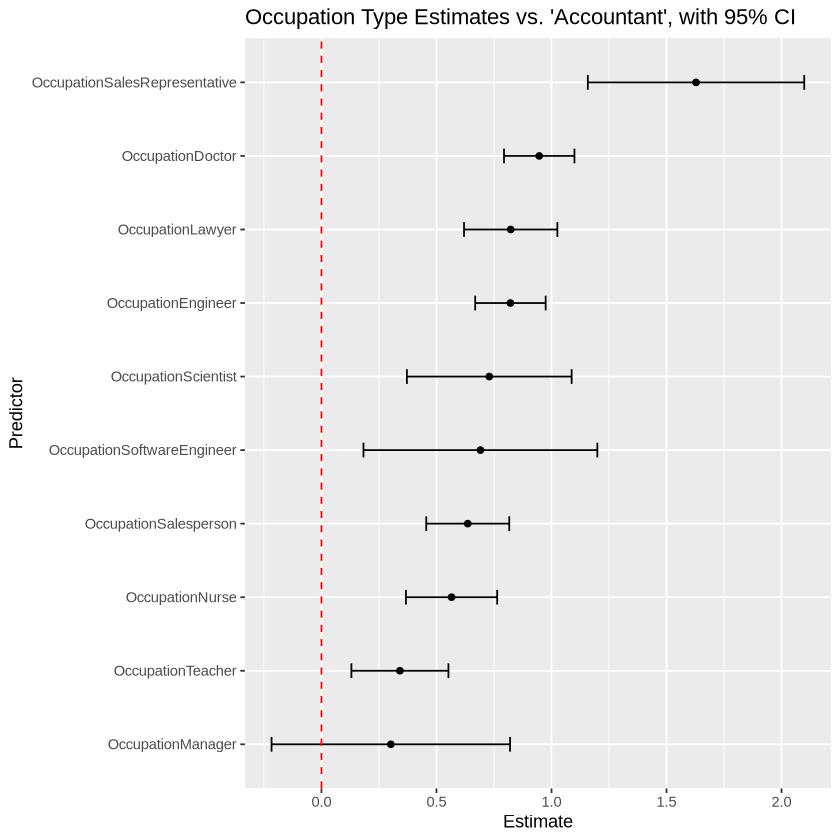

In [11]:
model_results <- tidy(aic_model, conf.int = TRUE) |>
  filter(term != "(Intercept)") |>
  mutate(direction = ifelse(p.value < 0.05,ifelse(estimate>0, "Positive", "Negative"), "Neither"))

occupation_vars <- model_results |> filter(grepl("^Occupation", term))
sleep_disorder_vars <- model_results |> filter(grepl("^SleepDisorder", term))
other_vars <- model_results |>
  filter(!grepl("^Occupation", term) & !grepl("^SleepDisorder", term))

plot_ci <- function(data, title) {
  ggplot(data, aes(x = estimate, y = reorder(term, estimate))) +
    geom_point() +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
    labs(title = title, x = "Estimate", y = "Predictor")
}

plot_ci(occupation_vars, "Occupation Type Estimates vs. 'Accountant', with 95% CI")

For sleep disorder:

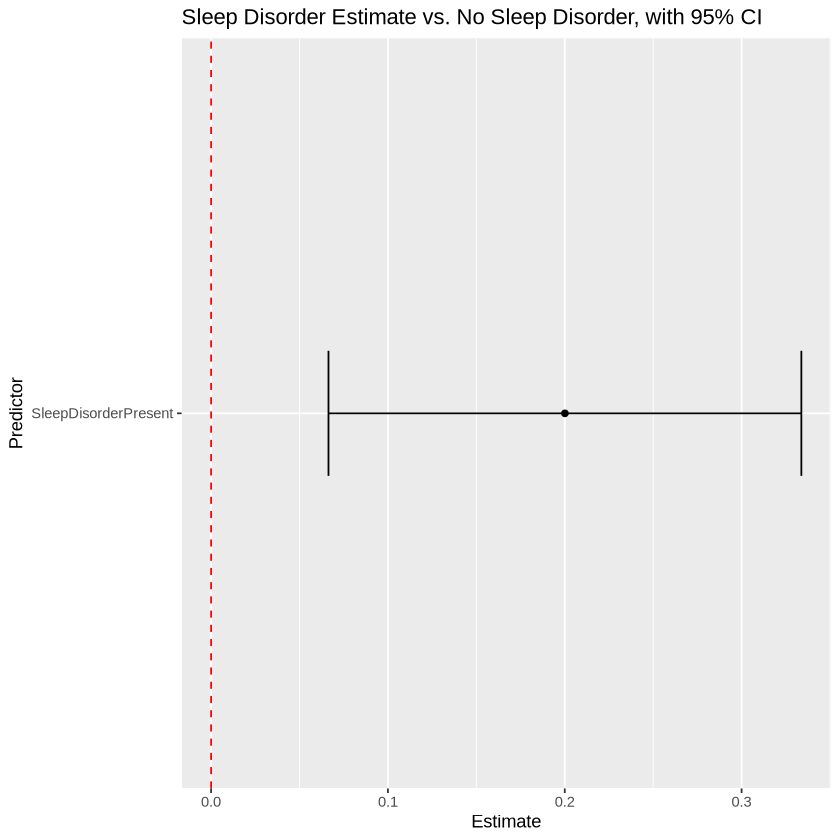

In [12]:
sleep_disorder_var <- model_results |> filter(grepl("^SleepDisorder", term))
plot_ci(sleep_disorder_var, "Sleep Disorder Estimate vs. No Sleep Disorder, with 95% CI")


For all other estimates:

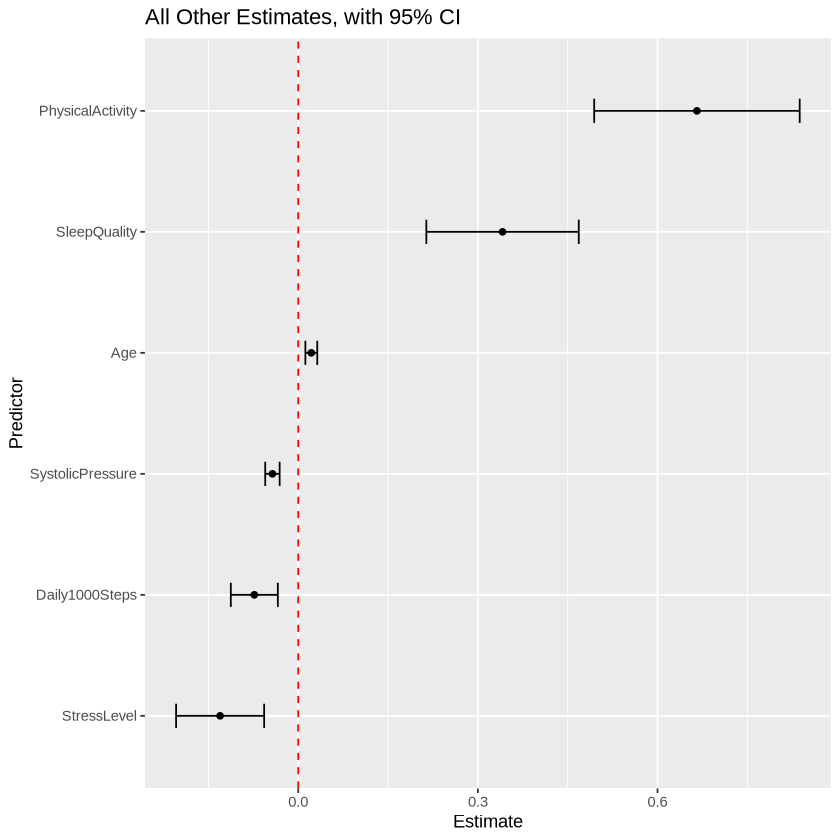

In [13]:
plot_ci(other_vars, "All Other Estimates, with 95% CI")

### Interpretation:

These graphs have a clean visualization of the significance of each predictor using mean and CI, as well as showing the direction of association, all corresponding to results we have explained above.

### FURTHER EXPLAIN VISUALIZATION HERE IF NEEDED. ***

### (Extra section)

Our model is mainly constructed for inference. However this little validation section with prediction using the testing set was included just to see what it would look like, since we have already used a split dataset system for model construction.

### THIS IS NOT PART OF MAIN PROJECT, DELETE LATER IF NEEDED

In [14]:
prediction_test <- predict(aic_model, newdata = sleep_test)
actual <- sleep_test$SleepDuration
residual <- actual - prediction_test
RMSE <- sqrt(mean(residual^2))
MAE <- mean(abs(residual))
R2 <- 1 - sum(residual^2) / sum((actual - mean(actual))^2)

print(c(RMSE = RMSE, MAE = MAE, R2 = R2))

mean_sleep <- mean(sleep_test$SleepDuration)
relative_RMSE <- RMSE / mean_sleep
relative_MAE <- MAE / mean_sleep

print(paste("RMSE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_RMSE,4)))
print(paste("MAE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_MAE,4)))

     RMSE       MAE        R2 
0.2974714 0.2148082 0.8540618 
[1] "RMSE RELATIVE TO MEAN SLEEP DURATION:  0.0416"
[1] "MAE RELATIVE TO MEAN SLEEP DURATION:  0.0301"


Summary:

- Relative RMSE: about 0.0416, good.
- Relative MAE: about 0.0301, good.
- R^2: 0.854, good.

# Discussion

### Put discussion part here ***

### extra diagnostics

In [15]:
#plot(aic_model)